# **630710729 นางสาวภารัณ พระสียา หอพักบ้านเบญจรงค์ จังหวัดนครปฐม**

#  ติดตั้งไลบรารีที่จำเป็นและImport

In [1]:
!pip install osmnx==1.9.1 folium -q

In [2]:
import osmnx as ox
import networkx as nx
import folium
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
ox.settings.use_cache = True
ox.settings.log_console = False

In [4]:
print(f"OSMnx version: {ox.__version__}")
print(f"NetworkX version: {nx.__version__}")

OSMnx version: 1.9.1
NetworkX version: 3.5


#ดึงข้อมูลแผนที่นครปฐม

In [5]:
place_name = "Nakhon Pathom,Thailand"

- Nodes (intersections): 50,481
- Edges (street segments): 115,364


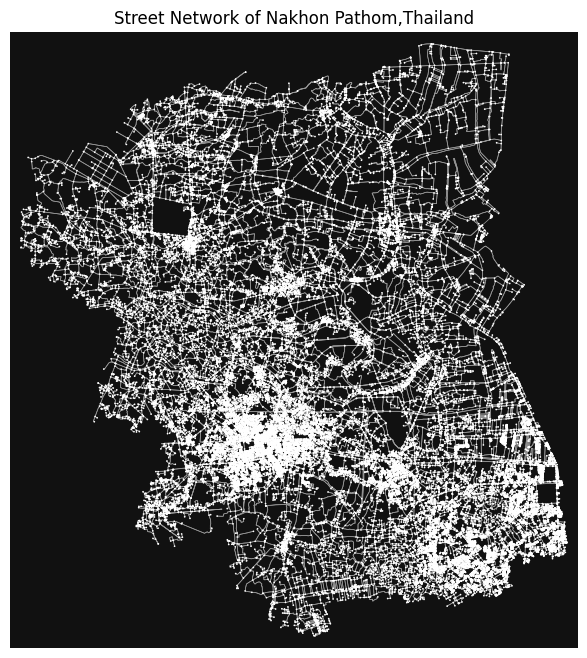

In [6]:
try:
    # ดึงข้อมูลเครือข่ายถนนสำหรับการขับรถ
    G = ox.graph_from_place(place_name, network_type='drive')

    print(f"- Nodes (intersections): {G.number_of_nodes():,}")
    print(f"- Edges (street segments): {G.number_of_edges():,}")

    fig, ax = ox.plot_graph(G, node_size=1.5, edge_linewidth=0.5, show=False, close=False)
    plt.title(f"Street Network of {place_name}")
    plt.show()

except Exception as e:
    print(f"Error downloading map data: {e}")

# สำรวจข้อมูลเบื้องต้น, Sample street , Types of roads in our graph

In [7]:
edges = ox.graph_to_gdfs(G, nodes=False)

print("🔍 Sample street data (first 5 streets):")
print(edges[['highway', 'length', 'name']].head())

print("\n📊 Types of roads in our graph:")
highway_counts = edges['highway'].value_counts()
print(highway_counts.head(10))

🔍 Sample street data (first 5 streets):
                               highway   length           name
u         v          key                                      
268631349 2286455597 0    primary_link   13.649            NaN
          8556088500 0         primary   12.658  ถนนเศรษฐกิจ 2
268631389 2286464669 0     residential   38.865            NaN
          2286437642 0         primary   42.632  ถนนเศรษฐกิจ 2
268631499 8508809475 0         primary  608.453  ถนนเศรษฐกิจ 2

📊 Types of roads in our graph:
highway
residential       87880
unclassified      15301
tertiary           7173
secondary          2548
primary            1170
trunk               594
trunk_link          150
primary_link        150
secondary_link      138
tertiary_link       121
Name: count, dtype: int64


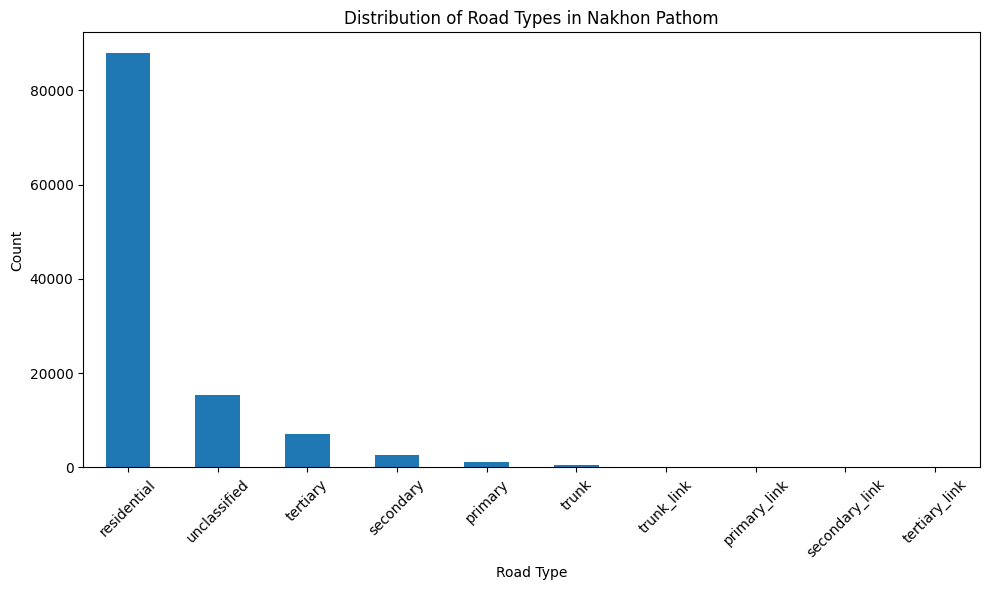

In [8]:
plt.figure(figsize=(10, 6))
highway_counts.head(10).plot(kind='bar')
plt.title("Distribution of Road Types in Nakhon Pathom")
plt.xlabel("Road Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# กำหนดจุดเริ่มต้นและปลายทาง

In [9]:
start_lat, start_lon = 13.813756057188902, 100.04694369546053
start_name = "หอพักบ้านเบญจรงค์ จังหวัดนครปฐม"

In [10]:
end_lat, end_lon = 13.8196, 100.0410
end_name = "มหาวิทยาลัยศิลปากร วิทยาเขตสนามจันทร์"

In [11]:
orig_node = ox.nearest_nodes(G, start_lon, start_lat)
dest_node = ox.nearest_nodes(G, end_lon, end_lat)

print(f"🚶 Starting point: {start_name}")
print(f"   Node ID: {orig_node}")
print(f"🎯 Destination: {end_name}")
print(f"   Node ID: {dest_node}")

🚶 Starting point: หอพักบ้านเบญจรงค์ จังหวัดนครปฐม
   Node ID: 5831364128
🎯 Destination: มหาวิทยาลัยศิลปากร วิทยาเขตสนามจันทร์
   Node ID: 1125952753


In [12]:
if nx.has_path(G, orig_node, dest_node):
    print("Path exists between origin and destination!")
else:
    print("No path found! Try different locations.")

Path exists between origin and destination!


In [13]:
try:
    # ใช้ A* algorithm หาเส้นทางที่สั้นที่สุด (ตามระยะทาง)
    shortest_route = nx.astar_path(G, orig_node, dest_node, weight='length')

    # คำนวณระยะทางรวม
    route_length = nx.path_weight(G, shortest_route, weight='length')

    print(f"✅ Shortest route found!")
    print(f"📏 Total distance: {route_length:,.0f} meters ({route_length/1000:.2f} km)")
    print(f"🔢 Number of intersections: {len(shortest_route)}")

except nx.NetworkXNoPath:
    print("❌ No path found between these locations!")
except Exception as e:
    print(f"❌ Error: {e}")

✅ Shortest route found!
📏 Total distance: 1,190 meters (1.19 km)
🔢 Number of intersections: 20


# แสดงผลเส้นทางบนแผนที่ Interactive

In [14]:
route_map = ox.plot_route_folium(G, shortest_route,
                                  route_color='red',
                                  route_width=5,
                                  route_opacity=0.8)

/tmp/ipython-input-14-562654551.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_map = ox.plot_route_folium(G, shortest_route,


In [15]:
start_marker = folium.Marker(
    location=[start_lat, start_lon],
    popup=f"<b>Start:</b> {start_name}",
    icon=folium.Icon(color='green', icon='play')
)
start_marker.add_to(route_map)

end_marker = folium.Marker(
    location=[end_lat, end_lon],
    popup=f"<b>End:</b> {end_name}",
    icon=folium.Icon(color='red', icon='stop')
)
end_marker.add_to(route_map)

In [16]:
print("🗺️ Interactive map (zoom in/out to explore):")
display(route_map)

🗺️ Interactive map (zoom in/out to explore):


# วิเคราะห์เส้นทาง

In [17]:
route_edges = ox.utils_graph.route_to_gdf(G, shortest_route, weight='length')

print("📊 Route Analysis:")
print(f"Total segments: {len(route_edges)}")
print(f"\n🛣️ Street names used:")

# รวบรวมชื่อถนนที่ใช้ (ไม่ซ้ำ)
street_names = route_edges['name'].dropna().unique()
for i, street in enumerate(street_names, 1):
    print(f"   {i}. {street}")

# แสดงประเภทถนนที่ใช้
print(f"\n🚗 Road types used:")
road_types = route_edges['highway'].value_counts()
for road_type, count in road_types.items():
    print(f"   - {road_type}: {count} segments")

📊 Route Analysis:
Total segments: 19

🛣️ Street names used:
   1. ถนน ราชมรรคา
   2. ถนนยิงเป้า
   3. ถนนทรงพล
   4. ถนนสนามจันทร์

🚗 Road types used:
   - tertiary: 8 segments
   - secondary: 7 segments
   - residential: 2 segments
   - unclassified: 2 segments


# ลองเปลี่ยนจุดหมายปลายทาง (เซ็นทรัล นครปฐม)

In [18]:
new_end_lat, new_end_lon = 13.805780064362123, 100.04836025309083
new_end_name = "เซ็นทรัล นครปฐม"

print(f"🎯 New destination: {new_end_name}")

🎯 New destination: เซ็นทรัล นครปฐม


In [19]:
new_dest_node = ox.nearest_nodes(G, new_end_lon, new_end_lat)
new_route = nx.astar_path(G, orig_node, new_dest_node, weight='length')
new_length = nx.path_weight(G, new_route, weight='length')

print(f"📏 Distance to new destination: {new_length:,.0f} meters ({new_length/1000:.2f} km)")
print(f"📊 Difference: {abs(new_length - route_length):,.0f} meters")

📏 Distance to new destination: 4,246 meters (4.25 km)
📊 Difference: 3,057 meters


In [20]:
comparison_map = ox.plot_route_folium(G, shortest_route,
                                      route_color='red',
                                      route_width=4,
                                      route_opacity=0.7)

comparison_map = ox.plot_route_folium(G, new_route,
                                      route_map=comparison_map,
                                      route_color='blue',
                                      route_width=4,
                                      route_opacity=0.7)

/tmp/ipython-input-20-2900661045.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  comparison_map = ox.plot_route_folium(G, shortest_route,
/tmp/ipython-input-20-2900661045.py:6: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  comparison_map = ox.plot_route_folium(G, new_route,


In [21]:
folium.Marker([start_lat, start_lon],
              popup=f"<b>Start:</b> {start_name}",
              icon=folium.Icon(color='green')).add_to(comparison_map)

folium.Marker([end_lat, end_lon],
              popup=f"<b>Destination 1:</b> {end_name}",
              icon=folium.Icon(color='red')).add_to(comparison_map)

folium.Marker([new_end_lat, new_end_lon],
              popup=f"<b>Destination 2:</b> {new_end_name}",
              icon=folium.Icon(color='blue')).add_to(comparison_map)

print("\n🗺️ Comparison map (Red = มหาวิทยาลัยศิลปากร, blue = เซ็นทรัล นครปฐม):")
display(comparison_map)


🗺️ Comparison map (Red = มหาวิทยาลัยศิลปากร, blue = เซ็นทรัล นครปฐม):


In [22]:
help(ox.graph_from_place)

Help on function graph_from_place in module osmnx.graph:

graph_from_place(query, network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, which_result=None, buffer_dist=None, clean_periphery=None, custom_filter=None)
    Download and create a graph within the boundaries of some place(s).
    
    The query must be geocodable and OSM must have polygon boundaries for the
    geocode result. If OSM does not have a polygon for this place, you can
    instead get its street network using the graph_from_address function,
    which geocodes the place name to a point and gets the network within some
    distance of that point.
    
    If OSM does have polygon boundaries for this place but you're not finding
    it, try to vary the query string, pass in a structured query dict, or vary
    the which_result argument to use a different geocode result. If you know
    the OSM ID of the place, you can retrieve its boundary polygon using the
    geocode_to_gdf function,

# เพิ่ม "travel time" เป็น weight แทน distance

In [23]:
# Define estimated travel speeds for different road types in km/h
speed_kmph = {
    'residential': 30,  # Typical speed in residential areas
    'unclassified': 30, # Similar to residential
    'tertiary': 40,     # Medium speed urban roads
    'secondary': 50,    # Arterial roads
    'primary': 60,      # Major urban roads
    'trunk': 70,        # Major highways/expressways within urban area
    'motorway': 90,     # High-speed expressways
    'living_street': 10,# Very low speed
    'service': 20,      # Service roads, alleys
    'road': 30,         # General unclassified roads
    'primary_link': 60, # Links to primary roads
    'secondary_link': 50,# Links to secondary roads
    'tertiary_link': 40, # Links to tertiary roads
    'trunk_link': 70,   # Links to trunk roads
    'motorway_link': 90 # Links to motorways
}

print("Estimated speeds (km/h) by road type")
for highway_type, speed in speed_kmph.items():
    print(f"  {highway_type}: {speed}")

Estimated speeds (km/h) by road type
  residential: 30
  unclassified: 30
  tertiary: 40
  secondary: 50
  primary: 60
  trunk: 70
  motorway: 90
  living_street: 10
  service: 20
  road: 30
  primary_link: 60
  secondary_link: 50
  tertiary_link: 40
  trunk_link: 70
  motorway_link: 90


# คำนวน travel time

In [24]:
# Convert speed from km/h to meters per second
speed_mps = {highway_type: speed * 1000 / 3600 for highway_type, speed in speed_kmph.items()}

# Add 'speed_mps' attribute to edges based on 'highway' type
G = ox.add_edge_speeds(G, speed_mps)

# Calculate and add 'travel_time' attribute to edges
G = ox.add_edge_travel_times(G)

In [25]:
edges = ox.graph_to_gdfs(G, nodes=False)
print("🚗 ตัวอย่างเวลาเดินทางในแต่ละเส้นถนน (5 แถวแรก):\n")
print(edges[['name', 'highway', 'length', 'speed_kph', 'travel_time']].head())

🚗 ตัวอย่างเวลาเดินทางในแต่ละเส้นถนน (5 แถวแรก):

                                   name       highway   length  speed_kph  \
u         v          key                                                    
268631349 2286455597 0              NaN  primary_link   13.649       16.7   
          8556088500 0    ถนนเศรษฐกิจ 2       primary   12.658       16.7   
268631389 2286464669 0              NaN   residential   38.865        8.3   
          2286437642 0    ถนนเศรษฐกิจ 2       primary   42.632       16.7   
268631499 8508809475 0    ถนนเศรษฐกิจ 2       primary  608.453       16.7   

                          travel_time  
u         v          key               
268631349 2286455597 0            2.9  
          8556088500 0            2.7  
268631389 2286464669 0           16.9  
          2286437642 0            9.2  
268631499 8508809475 0          131.2  


#shortest path จาก time

In [26]:
# ใช้ A* algorithm หาเส้นทางที่ใช้เวลาน้อยที่สุด
shortest_route_time = nx.astar_path(G, orig_node, dest_node, weight='travel_time')

# คำนวณเวลาการเดินทางรวม
route_time = nx.path_weight(G, shortest_route_time, weight='travel_time')

print(f"⏰ Estimated total travel time: {route_time:.2f} seconds ({route_time/60:.2f} minutes)")
print(f"Number of intersections: {len(shortest_route_time)}")

⏰ Estimated total travel time: 391.80 seconds (6.53 minutes)
Number of intersections: 20


# ตัวอย่างการกำหนดความเร็วให้แต่ละเส้นทาง

In [27]:
# ดึงข้อมูลจากกราฟจริง (จากเส้นทางที่คำนวณได้)
records = []

for u, v in zip(shortest_route[:-1], shortest_route[1:]):
    edge_data = G.get_edge_data(u, v)[0]

    length = edge_data.get('length', 1)  # ระยะทาง (เมตร)

    # สมมุติว่าใช้ความเร็วปกติ 30 km/h ถ้าไม่มีข้อมูล
    speed_kph = edge_data.get('speed_kph', 30)
    speed_mps = speed_kph * 1000 / 3600

    travel_time = length / speed_mps  # เวลา (วินาที)
    speed_mps_actual = length / travel_time  # ควรเท่ากับ speed_mps

    records.append({
        'u': u,
        'v': v,
        'key': 0,
        'length_m': length,
        'speed_kph': speed_kph,
        'speed_mps_actual': speed_mps_actual
    })

df_speeds_actual = pd.DataFrame(records)
display(df_speeds_actual)

,u,v,key,length_m,speed_kph,speed_mps_actual
0,5831364128,1217522572,0,75.898,8.3,2.305556
1,1217522572,1217522567,0,32.212,8.3,2.305556
2,1217522567,1217317868,0,15.997,11.1,3.083333
3,1217317868,5363673087,0,14.558,11.1,3.083333
4,5363673087,1203888809,0,13.804,11.1,3.083333
5,1203888809,1203888786,0,69.190,11.1,3.083333
6,1203888786,1203888794,0,24.386,11.1,3.083333
7,1203888794,5831364165,0,23.521,11.1,3.083333
8,5831364165,8679726633,0,80.799,11.1,3.083333
9,8679726633,1120781038,0,91.434,11.1,3.083333
